# How to create subgraphs

Graphs such as [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph)'s naturally can be composed. Creating subgraphs lets you build things like [multi-agent teams](./multi_agent/hierarchical_agent_teams.ipynb), where each team can track its own separate state.

You can add a `StateGraph` instance as a node by first [compiling](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph.compile) it to translate it to its lower-level Pregel operations.

The main thing you should note is ensuring the "handoff" from the calling graph to the called graph behaves as expected.

Below are a couple of examples showing how to do so!

First, install LangGraph.

In [2]:
%%capture --no-stderr
%pip install -U langgraph

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

## Create Parent + Child Graphs

For this example, we will create two graphs: a parent graph with a few nodes, and a child graph that is added as a node in the parent.

For this example we will use the same `State` in both graphs, though we will show how using the same keys can be a stumbling block if you're not careful.

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START


def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


child_builder = StateGraph(ChildState)

child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
child_builder.add_edge(START, "child_start")
child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})
child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})
child_builder.add_edge("child_start", "child_middle")
child_builder.add_edge("child_middle", "child_end")
child_builder.set_finish_point("child_end")

builder = StateGraph(ParentState)

builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
builder.add_edge(START, "grandparent")
builder.add_node("parent", lambda state: {"path": ["parent"]})
builder.add_node("child", child_builder.compile())
builder.add_node("sibling", lambda state: {"path": ["sibling"]})
builder.add_node("fin", lambda state: {"path": ["fin"]})

# Add connections
builder.add_edge("grandparent", "parent")
builder.add_edge("parent", "child")
builder.add_edge("parent", "sibling")
builder.add_edge("child", "fin")
builder.add_edge("sibling", "fin")
builder.set_finish_point("fin")
graph = builder.compile()

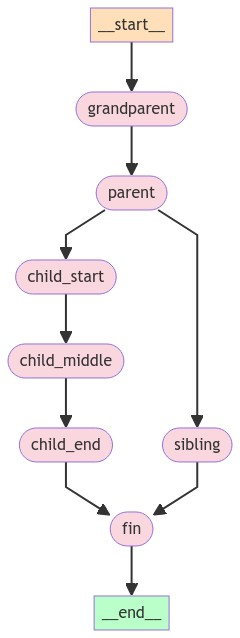

In [3]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [17]:
graph.invoke({"name": "test"}, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[0:checkpoint] State at the end of step 0:
{'name': 'test', 'path': []}
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[1:checkpoint] State at the end of step 1:
{'name': 'test', 'path': ['grandparent']}
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test', 'path': ['grandparent']}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[2:checkpoint] State at the end of step 2:
{'name': 'test', 'path': ['grandparent', 'parent']}
[3:tasks] Starting step 3 with 2 tasks:
- child -> {'name': 'test', 'path': ['grandparent', 'parent']}
- sibling -> {'name': 'test', 'path': ['grandparent', 'parent']}
[3:writes] Finished step 3 with writes to 2 channels:
- name -> 'test'
- path -> ['grandparent', 'parent', '

{'name': 'test',
 'path': ['grandparent',
  'parent',
  'grandparent',
  'parent',
  'child_start',
  'child_middle',
  'child_end',
  'sibling',
  'fin']}

Notice here that the `["grandparent", "parent"]` sequence is duplicated! This is because our child state has received the full parent state and returns the full parent state once it terminates. To avoid duplication or conflicts in state, you typically would do one or more of the following:

1. Handle duplicates in your `reducer` function.
2. Call the child graph from within a python function. In that function, handle the state as needed.  
3. Update the child graph keys to avoid conflicts. You would still need to ensure the output can be interpreted by the parent, however.

Let's re-implement the graph using technique (1) and add unique IDs for every value in the list. This is what is done in [`MessageGraph`](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.MessageGraph).

In [23]:
import uuid


def reduce_list(left: list | None, right: list | None) -> list:
    """Append the right-hand list, replacing any elements with the same id in the left-hand list."""
    if not left:
        left = []
    if not right:
        right = []
    left_, right_ = [], []
    for orig, new in [(left, left_), (right, right_)]:
        for val in orig:
            if not isinstance(val, dict):
                val = {"val": val}
            if "id" not in val:
                val["id"] = str(uuid.uuid4())
            new.append(val)
    # Merge the two lists
    left_idx_by_id = {val["id"]: i for i, val in enumerate(left_)}
    merged = left_.copy()
    for val in right_:
        if (existing_idx := left_idx_by_id.get(val["id"])) is not None:
            merged[existing_idx] = val
        else:
            merged.append(val)
    return merged


class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]

In [24]:
child_builder = StateGraph(ChildState)

child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
child_builder.add_edge(START, "child_start")
child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})
child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})
child_builder.add_edge("child_start", "child_middle")
child_builder.add_edge("child_middle", "child_end")
child_builder.set_finish_point("child_end")

builder = StateGraph(ParentState)

builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
builder.add_edge(START, "grandparent")
builder.add_node("parent", lambda state: {"path": ["parent"]})
builder.add_node("child", child_builder.compile())
builder.add_node("sibling", lambda state: {"path": ["sibling"]})
builder.add_node("fin", lambda state: {"path": ["fin"]})

# Add connections
builder.add_edge("grandparent", "parent")
builder.add_edge("parent", "child")
builder.add_edge("parent", "sibling")
builder.add_edge("child", "fin")
builder.add_edge("sibling", "fin")
builder.set_finish_point("fin")
graph = builder.compile()

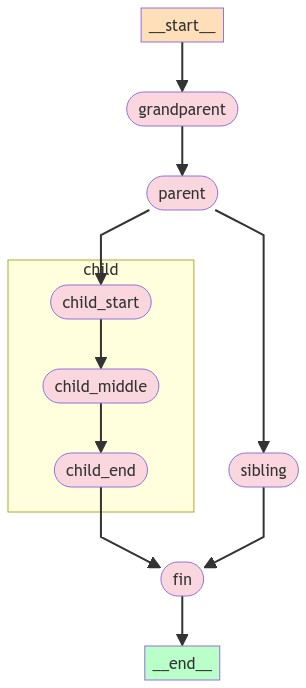

In [25]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
graph.invoke({"name": "test"}, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[0:checkpoint] State at the end of step 0:
{'name': 'test', 'path': []}
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[1:checkpoint] State at the end of step 1:
{'name': 'test',
 'path': [{'id': '79a81f03-d16d-4d12-94a6-4ba29fc9ce49', 'val': 'grandparent'}]}
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test',
 'path': [{'id': '79a81f03-d16d-4d12-94a6-4ba29fc9ce49', 'val': 'grandparent'}]}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[2:checkpoint] State at the end of step 2:
{'name': 'test',
 'path': [{'id': '79a81f03-d16d-4d12-94a6-4ba29fc9ce49', 'val': 'grandparent'},
          {'id': '2a6f0263-3949-4e47-a210-57f817e6097d', 'val': 'parent'}]}
[3:tasks] Starting step 3 with 2 tasks:
- c

{'name': 'test',
 'path': [{'val': 'grandparent', 'id': '79a81f03-d16d-4d12-94a6-4ba29fc9ce49'},
  {'val': 'parent', 'id': '2a6f0263-3949-4e47-a210-57f817e6097d'},
  {'val': 'child_start', 'id': 'd1c1bab0-6e19-4846-a470-e9cc2eb85088'},
  {'val': 'child_middle', 'id': 'e0fcb647-1e9e-4ae4-b560-0046515d5783'},
  {'val': 'child_end', 'id': '669dd810-360f-4694-a9f3-49597f23376a'},
  {'val': 'sibling', 'id': '137dbc2f-b33c-4ea4-8b04-a62215ba9718'},
  {'val': 'fin', 'id': 'a4328c5f-845a-43de-b3d7-53a39208e316'}]}